In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = SparkSession \
    .builder \
    .appName("claims") \
    .getOrCreate()

In [3]:
#%%time
#!cat harvester/claims/*CLAIMS*jsonl > harvester/claims/aggregated.jsonl

In [4]:
%%time
df = spark.read.json("harvester/claims/aggregated.jsonl")

CPU times: user 3.51 ms, sys: 463 µs, total: 3.97 ms
Wall time: 2.07 s


In [5]:
!wc -l harvester/claims/aggregated.jsonl

2998 harvester/claims/aggregated.jsonl


In [6]:
!cat harvester/claims/aggregated.jsonl | grep '2023-12-08'

grep: (standard input): binary file matches


In [7]:
df.count()

2998

In [8]:
df = df.where("version = '0.0.2'")
df.sort(F.col("scraped_at").desc()).show()

+---------------+------+-------------+--------------------+--------------------+--------------------+-------+
|_corrupt_record| claim|      crawler|          scraped_at|                 url|                uuid|version|
+---------------+------+-------------+--------------------+--------------------+--------------------+-------+
|           null|135512|ClaimsCrawler|2023-12-08 12:31:...|https://www.occ.c...|cc454ec7-248e-4b7...|  0.0.2|
|           null| 95462|ClaimsCrawler|2023-12-08 12:31:...|https://co.comput...|66eee0f0-032a-49e...|  0.0.2|
|           null|130038|ClaimsCrawler|2023-12-08 12:31:...|https://mx.comput...|0d6f5113-5470-4cd...|  0.0.2|
|           null|135464|ClaimsCrawler|2023-12-08 12:00:...|https://www.occ.c...|e88c310e-336e-451...|  0.0.2|
|           null| 95459|ClaimsCrawler|2023-12-08 12:00:...|https://co.comput...|e3d30409-2f59-409...|  0.0.2|
|           null|130082|ClaimsCrawler|2023-12-08 12:00:...|https://mx.comput...|24426773-d6e6-456...|  0.0.2|
|         

<Figure size 1800x600 with 0 Axes>

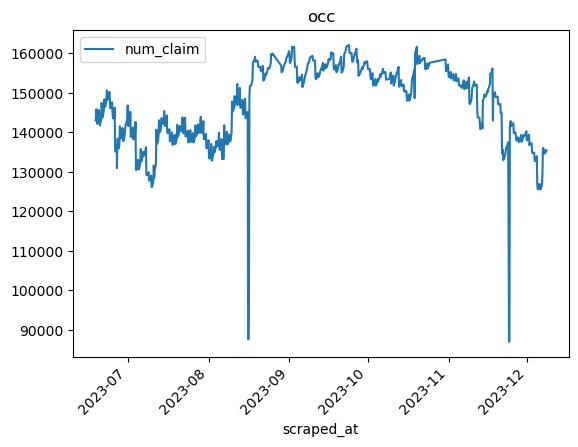

In [9]:
plt.figure(figsize=(18,6))
data = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data['scraped_at'] = pd.to_datetime(data['scraped_at'])
data.plot("scraped_at", "num_claim")
plt.title("occ")
_ = plt.xticks(rotation=45)

In [10]:
data

,_corrupt_record,claim,crawler,scraped_at,url,uuid,version,num_claim
0,None,143063,ClaimsCrawler,2023-06-18 16:00:44.927250,https://www.occ.com.mx/empleos/de--/,082e38b5-6379-46b3-ac33-de0a647ffadf,0.0.2,143063
1,None,143082,ClaimsCrawler,2023-06-18 20:00:44.329050,https://www.occ.com.mx/empleos/de--/,2a30674c-ca13-4da2-a3f9-bfb2adef5545,0.0.2,143082
2,None,145898,ClaimsCrawler,2023-06-19 00:00:48.557039,https://www.occ.com.mx/empleos/de--/,5b908799-73e2-4106-9b86-f9b97decd67e,0.0.2,145898
3,None,144438,ClaimsCrawler,2023-06-19 04:00:45.723339,https://www.occ.com.mx/empleos/de--/,7eb416ae-0c05-4a83-8e77-82f65c16657e,0.0.2,144438
4,None,142183,ClaimsCrawler,2023-06-19 08:00:45.075144,https://www.occ.com.mx/empleos/de--/,4646343c-2338-48b3-bf1b-15588d2586ed,0.0.2,142183
...,...,...,...,...,...,...,...,...
966,None,134686,ClaimsCrawler,2023-12-08 00:00:50.163209,https://www.occ.com.mx/empleos/de--/,f8d8d925-36d0-4476-9da6-f6fc8f1acc23,0.0.2,134686
967,None,135162,ClaimsCrawler,2023-12-08 04:00:49.079388,https://www.occ.com.mx/empleos/de--/,dd746a1e-49b5-4a8c-92d8-3a2ff94b2f86,0.0.2,135162
968,None,135187,ClaimsCrawler,2023-12-08 08:00:51.602027,https://www.occ.com.mx/empleos/de--/,286f7bff-b008-4713-abe3-3e83c4a62f02,0.0.2,135187
969,None,135464,ClaimsCrawler,2023-12-08 12:00:53.561554,https://www.occ.com.mx/empleos/de--/,e88c310e-336e-4516-ac0e-55d0b4b7668b,0.0.2,135464


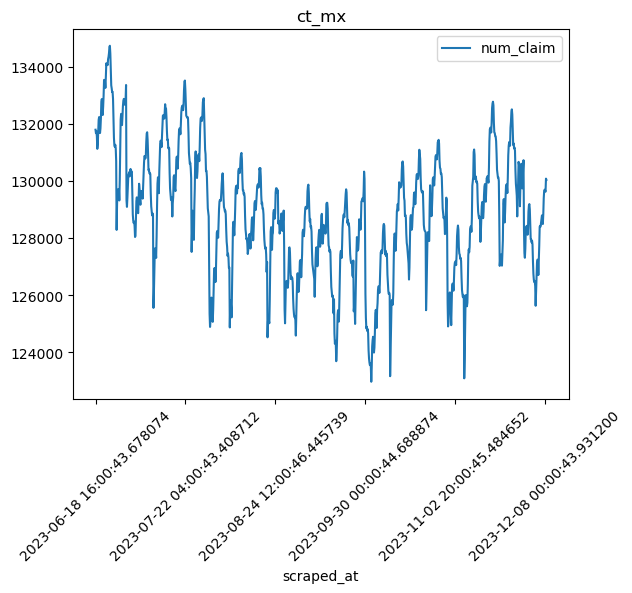

In [11]:
data = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_mx")
_ = plt.xticks(rotation=45)

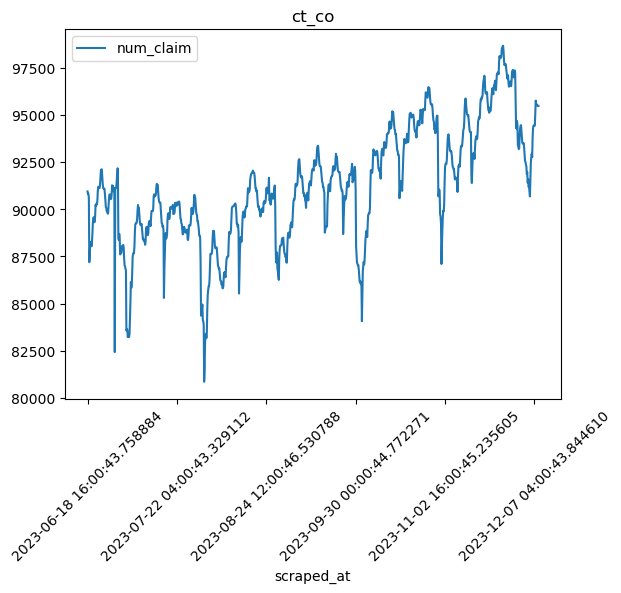

In [12]:
data = df.where(df.url.startswith("https://co.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).toPandas()
data.plot("scraped_at", "num_claim")
plt.title("ct_co")
_ = plt.xticks(rotation=45)

In [13]:
spark.sparkContext.defaultParallelism

4

In [14]:
df.rdd.getNumPartitions()

1

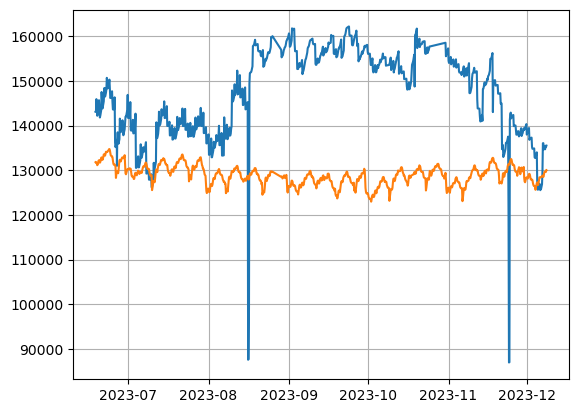

In [15]:
ct = df.where(df.url.startswith("https://mx.computrabajo")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()
occ = df.where(df.url.startswith("https://www.occ")).sort("scraped_at").withColumn("num_claim", df["claim"].cast("int")).select("scraped_at", "num_claim").toPandas()

ct['scraped_at'] = pd.to_datetime(ct['scraped_at'])
occ['scraped_at'] = pd.to_datetime(occ['scraped_at'])

plt.plot(occ.set_index('scraped_at'))
plt.plot(ct.set_index('scraped_at'))
plt.grid(which="both")
plt.show()

In [16]:
ct_ts["num_claim"]

NameError: name 'ct_ts' is not defined

In [ ]:
occ_ts = occ.set_index("scraped_at")
ct_ts = ct.set_index("scraped_at")
plt.plot(occ_ts.index, occ_ts["num_claim"])
plt.plot(ct_ts.index, ct_ts["num_claim"])

In [ ]:
plt.plot(occ["num_claim"])
plt.plot(ct["num_claim"])
plt.ylim(bottom=0)
plt.show()